# Importación de librerías

In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyeeg
import math
import scipy

import os
import seaborn as sn

#Importación de librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import joblib
from joblib import dump, load

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-7zkuemoq
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-7zkuemoq
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=c39d534dd1795599dd4a3da8ecd8481cf9e6e847434483370928e0320c713e09
  Stored in directory: /tmp/pip-ephem-wheel-cache-m272hns9/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg
Mounted at /content/drive


# Lectura de archivos y extracción de características

In [ ]:
FOLDER_PATH = 'Tesis/Concentracion'
ROOT_PATH = '/content/drive/MyDrive/'
files_quantity = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))

sfreq = 1000 # Frecuencia a la que toma datos el BIOPAC
t_epoch = 10 # Se realiza un epoch cada 10 segundos
t_relajacion = 60 #Tiempo en segundos
t_concentracion = 180 # Tiempo en segundos
band_freq = [0.5,4,7,12,30,50]
sujeto = 1
prueba = 1
epochs_trained = pd.DataFrame(columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PFD','DE','Power Delta','Power Theta','Power Alpha','Power Beta',
                                       'Power Gamma','Power Delta Normalized','Power Theta Normalized','Power Alpha Normalized','Power Beta Normalized',
                                       'Power Gamma Normalized','Hjorth Mobility','Hjorth Complexity'])

tests_to_evaluate = 1
tests_per_subject = 3
no_subjects = (files_quantity//tests_per_subject)
files_to_analyze = no_subjects*tests_to_evaluate

discarded_subjects = [5,11,12]

def extractPSD(PSD_value):
  return [PSD_value[0][0], PSD_value[0][1], PSD_value[0][2], PSD_value[0][3], PSD_value[0][4], PSD_value[1][0], PSD_value[1][1], PSD_value[1][2], PSD_value[1][3], PSD_value[1][4]]

def extractHjorth(Hjorth_value):
  return [Hjorth_value[0],Hjorth_value[1]]


for i in range(files_to_analyze):
  if sujeto in discarded_subjects:
    sujeto = sujeto + 1
  else:
    if sujeto < 10:
      subject = '0' + str(sujeto)
    else:
      subject = str(sujeto)
    df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/'+subject+'0'+str(prueba)+'.csv')
    print('Lectura de archivo: '+subject+'0'+str(prueba)+'.csv')
    sujeto = sujeto + 1
    df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
    epochs = []
    j = 0
    for k in range(len(df)):
      epochs.append(j)
      if (k+1) % (sfreq*t_epoch) == 0:
        j += 1
    df.insert(0,'Epoch',epochs)
    df2 = pd.DataFrame(columns=['EEG','Epoch'])
    df2['EEG'], df2['Epoch'] = df['EEG'], df['Epoch']
    temp=df2.groupby(['Epoch']).agg([pyeeg.dfa,
                                        #lambda x: pyeeg.hurst(x.tolist()),
                                        lambda x: pyeeg.hfd(x.tolist(),5),
                                        #lambda x: pyeeg.spectral_entropy(x.tolist(),band_list,sfreq,Power_Ratio=None),
                                        lambda x: pyeeg.fisher_info(x.tolist(),4,10),
                                        # lambda x: pyeeg.ap_entropy(x,10,0.3*(np.std(x))),
                                        lambda x: pyeeg.svd_entropy(x,4,10),
                                        lambda x: pyeeg.bin_power(x, band_freq, sfreq),
                                        lambda x: pyeeg.pfd(x, np.diff(x).tolist()),
                                        lambda x: pyeeg.hjorth(x.tolist(), np.diff(x).tolist()),
                                        lambda x: scipy.stats.differential_entropy(x, window_length=None, base=None, axis=0, method='auto')])

    temp.reset_index(inplace=True,drop=False)
    temp.columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PSD','PFD','Hjorth','DE']

    temp[['Power Delta',
        'Power Theta',
        'Power Alpha',
        'Power Beta',
        'Power Gamma',
        'Power Delta Normalized',
        'Power Theta Normalized',
        'Power Alpha Normalized',
        'Power Beta Normalized',
        'Power Gamma Normalized']] = temp['PSD'].apply(lambda x: pd.Series(extractPSD(x)))
    temp = temp.drop('PSD', axis=1)
    temp[['Hjorth Mobility','Hjorth Complexity']] = temp['Hjorth'].apply(lambda x: pd.Series(extractHjorth(x)))
    temp = temp.drop('Hjorth', axis=1)
    epochs_trained.append(temp)
    epochs_trained = pd.concat([epochs_trained,temp], ignore_index=True, sort=False)

display(epochs_trained)

Lectura de archivo: 0101.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0201.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0301.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0401.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0601.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0701.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0801.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 0901.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

Lectura de archivo: 1001.csv


<ipython-input-2-2733515e458b>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=N

,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,Power Alpha,Power Beta,Power Gamma,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity
0,0,1.213725,0.022238,1.448472,1.448472,0.618937,3.639500,252939.933860,82488.612510,70645.285448,249269.591651,161753.679443,0.309559,0.100953,0.086459,0.305067,0.197961,0.000668,484.154443
1,1,1.153997,0.021144,1.431447,1.431447,0.618594,3.666386,214073.772083,95214.551478,82707.312255,252756.679326,156647.531687,0.267125,0.118810,0.103204,0.315394,0.195467,0.000651,353.397664
2,2,1.176179,0.020867,1.393918,1.393918,0.619398,3.905852,279105.696194,84881.179188,92035.313623,283941.026778,198056.775831,0.297548,0.090490,0.098117,0.302703,0.211143,0.000613,373.628279
3,3,1.143164,0.018971,1.464267,1.464267,0.621797,3.576510,260945.478284,99176.092480,101357.487885,252117.978949,151632.384072,0.301591,0.114624,0.117145,0.291389,0.175251,0.000691,421.057792
4,4,1.050315,0.020521,1.523796,1.523796,0.621488,3.523924,224321.885013,70466.424993,77938.842444,290757.684652,191860.940041,0.262259,0.082384,0.091120,0.339930,0.224308,0.000817,387.860604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,19,0.980244,0.020002,1.489292,1.489292,0.619456,3.313090,167601.619124,64391.388303,80357.814237,224290.568365,122276.878475,0.254359,0.097723,0.121954,0.340392,0.185572,0.000734,361.035864
212,20,1.044870,0.022856,1.622356,1.622356,0.619340,3.697064,213637.274654,75419.976083,86309.395196,395081.448043,248766.745504,0.209610,0.073998,0.084682,0.387633,0.244077,0.000930,264.680042
213,21,1.256080,0.019503,1.381351,1.381351,0.621366,3.696319,258714.258288,85721.220689,97365.116119,229254.481980,147485.802106,0.316068,0.104724,0.118950,0.280077,0.180181,0.000593,435.400364
214,22,0.996888,0.021293,1.581382,1.581382,0.618822,3.167897,140032.290756,48790.321505,86757.917243,223652.972223,125932.626246,0.223992,0.078044,0.138776,0.357750,0.201439,0.000883,314.009683


In [ ]:
# Replace infinite updated data with nan
epochs_trained.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
epochs_trained.dropna(inplace=True)
epochs_trained.reset_index(inplace=True)
display(epochs_trained)

,index,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,Power Alpha,Power Beta,Power Gamma,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity
0,0,0,1.213725,0.022238,1.448472,1.448472,0.618937,3.639500,252939.933860,82488.612510,70645.285448,249269.591651,161753.679443,0.309559,0.100953,0.086459,0.305067,0.197961,0.000668,484.154443
1,1,1,1.153997,0.021144,1.431447,1.431447,0.618594,3.666386,214073.772083,95214.551478,82707.312255,252756.679326,156647.531687,0.267125,0.118810,0.103204,0.315394,0.195467,0.000651,353.397664
2,2,2,1.176179,0.020867,1.393918,1.393918,0.619398,3.905852,279105.696194,84881.179188,92035.313623,283941.026778,198056.775831,0.297548,0.090490,0.098117,0.302703,0.211143,0.000613,373.628279
3,3,3,1.143164,0.018971,1.464267,1.464267,0.621797,3.576510,260945.478284,99176.092480,101357.487885,252117.978949,151632.384072,0.301591,0.114624,0.117145,0.291389,0.175251,0.000691,421.057792
4,4,4,1.050315,0.020521,1.523796,1.523796,0.621488,3.523924,224321.885013,70466.424993,77938.842444,290757.684652,191860.940041,0.262259,0.082384,0.091120,0.339930,0.224308,0.000817,387.860604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,211,19,0.980244,0.020002,1.489292,1.489292,0.619456,3.313090,167601.619124,64391.388303,80357.814237,224290.568365,122276.878475,0.254359,0.097723,0.121954,0.340392,0.185572,0.000734,361.035864
210,212,20,1.044870,0.022856,1.622356,1.622356,0.619340,3.697064,213637.274654,75419.976083,86309.395196,395081.448043,248766.745504,0.209610,0.073998,0.084682,0.387633,0.244077,0.000930,264.680042
211,213,21,1.256080,0.019503,1.381351,1.381351,0.621366,3.696319,258714.258288,85721.220689,97365.116119,229254.481980,147485.802106,0.316068,0.104724,0.118950,0.280077,0.180181,0.000593,435.400364
212,214,22,0.996888,0.021293,1.581382,1.581382,0.618822,3.167897,140032.290756,48790.321505,86757.917243,223652.972223,125932.626246,0.223992,0.078044,0.138776,0.357750,0.201439,0.000883,314.009683


# Escalado de los datos

In [ ]:
scaler = StandardScaler()

In [ ]:
epochs_trained[['DE_T','Power Gamma Normalized_T']] = scaler.fit_transform(epochs_trained[['DE','Power Gamma Normalized']])

In [ ]:
epochs_trained

,index,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,...,Power Gamma,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity,DE_T,Power Gamma Normalized_T
0,0,0,1.213725,0.022238,1.448472,1.448472,0.618937,3.639500,252939.933860,82488.612510,...,161753.679443,0.309559,0.100953,0.086459,0.305067,0.197961,0.000668,484.154443,-0.430419,-0.602705
1,1,1,1.153997,0.021144,1.431447,1.431447,0.618594,3.666386,214073.772083,95214.551478,...,156647.531687,0.267125,0.118810,0.103204,0.315394,0.195467,0.000651,353.397664,-0.382182,-0.632165
2,2,2,1.176179,0.020867,1.393918,1.393918,0.619398,3.905852,279105.696194,84881.179188,...,198056.775831,0.297548,0.090490,0.098117,0.302703,0.211143,0.000613,373.628279,0.047447,-0.446994
3,3,3,1.143164,0.018971,1.464267,1.464267,0.621797,3.576510,260945.478284,99176.092480,...,151632.384072,0.301591,0.114624,0.117145,0.291389,0.175251,0.000691,421.057792,-0.543429,-0.870967
4,4,4,1.050315,0.020521,1.523796,1.523796,0.621488,3.523924,224321.885013,70466.424993,...,191860.940041,0.262259,0.082384,0.091120,0.339930,0.224308,0.000817,387.860604,-0.637774,-0.291489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,211,19,0.980244,0.020002,1.489292,1.489292,0.619456,3.313090,167601.619124,64391.388303,...,122276.878475,0.254359,0.097723,0.121954,0.340392,0.185572,0.000734,361.035864,-1.016034,-0.749051
210,212,20,1.044870,0.022856,1.622356,1.622356,0.619340,3.697064,213637.274654,75419.976083,...,248766.745504,0.209610,0.073998,0.084682,0.387633,0.244077,0.000930,264.680042,-0.327143,-0.057973
211,213,21,1.256080,0.019503,1.381351,1.381351,0.621366,3.696319,258714.258288,85721.220689,...,147485.802106,0.316068,0.104724,0.118950,0.280077,0.180181,0.000593,435.400364,-0.328478,-0.812729
212,214,22,0.996888,0.021293,1.581382,1.581382,0.618822,3.167897,140032.290756,48790.321505,...,125932.626246,0.223992,0.078044,0.138776,0.357750,0.201439,0.000883,314.009683,-1.276525,-0.561630


# Aplicación de KMeans Clustering

In [ ]:
epochs_trained['DE'] = pd.to_numeric(epochs_trained['DE'])
count = np.isinf(epochs_trained['DE']).values.sum()
print("It contains " + str(count) + " infinite values")

valores = np.isinf(epochs_trained['DE']).values
print(valores)

It contains 0 infinite values
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False Fa

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(epochs_trained[['DE_T','Power Gamma Normalized_T']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

,index,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,...,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity,DE_T,Power Gamma Normalized_T,k_means2
0,0,0,1.213725,0.022238,1.448472,1.448472,0.618937,3.639500,252939.933860,82488.612510,...,0.309559,0.100953,0.086459,0.305067,0.197961,0.000668,484.154443,-0.430419,-0.602705,0
1,1,1,1.153997,0.021144,1.431447,1.431447,0.618594,3.666386,214073.772083,95214.551478,...,0.267125,0.118810,0.103204,0.315394,0.195467,0.000651,353.397664,-0.382182,-0.632165,0
2,2,2,1.176179,0.020867,1.393918,1.393918,0.619398,3.905852,279105.696194,84881.179188,...,0.297548,0.090490,0.098117,0.302703,0.211143,0.000613,373.628279,0.047447,-0.446994,0
3,3,3,1.143164,0.018971,1.464267,1.464267,0.621797,3.576510,260945.478284,99176.092480,...,0.301591,0.114624,0.117145,0.291389,0.175251,0.000691,421.057792,-0.543429,-0.870967,0
4,4,4,1.050315,0.020521,1.523796,1.523796,0.621488,3.523924,224321.885013,70466.424993,...,0.262259,0.082384,0.091120,0.339930,0.224308,0.000817,387.860604,-0.637774,-0.291489,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,211,19,0.980244,0.020002,1.489292,1.489292,0.619456,3.313090,167601.619124,64391.388303,...,0.254359,0.097723,0.121954,0.340392,0.185572,0.000734,361.035864,-1.016034,-0.749051,0
210,212,20,1.044870,0.022856,1.622356,1.622356,0.619340,3.697064,213637.274654,75419.976083,...,0.209610,0.073998,0.084682,0.387633,0.244077,0.000930,264.680042,-0.327143,-0.057973,0
211,213,21,1.256080,0.019503,1.381351,1.381351,0.621366,3.696319,258714.258288,85721.220689,...,0.316068,0.104724,0.118950,0.280077,0.180181,0.000593,435.400364,-0.328478,-0.812729,0
212,214,22,0.996888,0.021293,1.581382,1.581382,0.618822,3.167897,140032.290756,48790.321505,...,0.223992,0.078044,0.138776,0.357750,0.201439,0.000883,314.009683,-1.276525,-0.561630,0


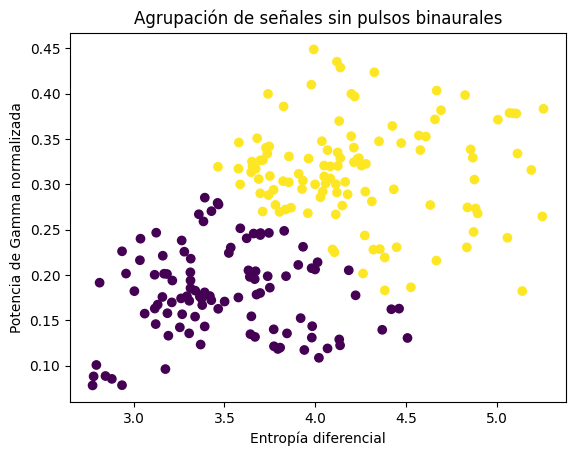

In [ ]:
epochs_trained['k_means2'] = kmeans.labels_
display(epochs_trained)
plt.scatter(x=epochs_trained['DE'],y=epochs_trained['Power Gamma Normalized'],c=epochs_trained['k_means2'])
plt.xlabel('Entropía diferencial')
plt.ylabel('Potencia de Gamma normalizada')
plt.title('Agrupación de señales sin pulsos binaurales')
plt.savefig('kmeans_ea_sin_pulsos.eps',format='eps')
plt.show()

# Evaluación de impacto de pulsos binaurales
### Se realiza una comparación entre el KMeans realizado con la data de la primera prueba con la data de la segunda prueba

In [ ]:
FOLDER_PATH = 'Tesis/Concentracion'
ROOT_PATH = '/content/drive/MyDrive/'
files_quantity = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))

sfreq = 1000 # Frecuencia a la que toma datos el BIOPAC
t_epoch = 10 # Se realiza un epoch cada 10 segundos
t_relajacion = 60 #Tiempo en segundos
t_concentracion = 180 # Tiempo en segundos
band_freq = [0.5,4,7,12,30,50]
sujeto = 1
prueba = 2
epochs_trained_1 = pd.DataFrame(columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PFD','DE','Power Delta','Power Theta','Power Alpha','Power Beta',
                                       'Power Gamma','Power Delta Normalized','Power Theta Normalized','Power Alpha Normalized','Power Beta Normalized',
                                       'Power Gamma Normalized','Hjorth Mobility','Hjorth Complexity'])

tests_to_evaluate = 1
tests_per_subject = 3
no_subjects = (files_quantity//tests_per_subject)
files_to_analyze = no_subjects*tests_to_evaluate

discarded_subjects = [5,11,12]

def extractPSD(PSD_value):
  return [PSD_value[0][0], PSD_value[0][1], PSD_value[0][2], PSD_value[0][3], PSD_value[0][4], PSD_value[1][0], PSD_value[1][1], PSD_value[1][2], PSD_value[1][3], PSD_value[1][4]]

def extractHjorth(Hjorth_value):
  return [Hjorth_value[0],Hjorth_value[1]]


for i in range(files_to_analyze):
  if sujeto in discarded_subjects:
    sujeto = sujeto + 1
  else:
    if sujeto < 10:
      subject = '0' + str(sujeto)
    else:
      subject = str(sujeto)
    df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/'+subject+'0'+str(prueba)+'.csv')
    print('Lectura de archivo: '+subject+'0'+str(prueba)+'.csv')
    sujeto = sujeto + 1
    df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
    epochs = []
    j = 0
    for k in range(len(df)):
      epochs.append(j)
      if (k+1) % (sfreq*t_epoch) == 0:
        j += 1
    df.insert(0,'Epoch',epochs)
    df2 = pd.DataFrame(columns=['EEG','Epoch'])
    df2['EEG'], df2['Epoch'] = df['EEG'], df['Epoch']
    temp=df2.groupby(['Epoch']).agg([pyeeg.dfa,
                                        #lambda x: pyeeg.hurst(x.tolist()),
                                        lambda x: pyeeg.hfd(x.tolist(),5),
                                        #lambda x: pyeeg.spectral_entropy(x.tolist(),band_list,sfreq,Power_Ratio=None),
                                        lambda x: pyeeg.fisher_info(x.tolist(),4,10),
                                        # lambda x: pyeeg.ap_entropy(x,10,0.3*(np.std(x))),
                                        lambda x: pyeeg.svd_entropy(x,4,10),
                                        lambda x: pyeeg.bin_power(x, band_freq, sfreq),
                                        lambda x: pyeeg.pfd(x, np.diff(x).tolist()),
                                        lambda x: pyeeg.hjorth(x.tolist(), np.diff(x).tolist()),
                                        lambda x: scipy.stats.differential_entropy(x, window_length=None, base=None, axis=0, method='auto')])

    temp.reset_index(inplace=True,drop=False)
    temp.columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PSD','PFD','Hjorth','DE']

    temp[['Power Delta',
        'Power Theta',
        'Power Alpha',
        'Power Beta',
        'Power Gamma',
        'Power Delta Normalized',
        'Power Theta Normalized',
        'Power Alpha Normalized',
        'Power Beta Normalized',
        'Power Gamma Normalized']] = temp['PSD'].apply(lambda x: pd.Series(extractPSD(x)))
    temp = temp.drop('PSD', axis=1)
    temp[['Hjorth Mobility','Hjorth Complexity']] = temp['Hjorth'].apply(lambda x: pd.Series(extractHjorth(x)))
    temp = temp.drop('Hjorth', axis=1)
    epochs_trained_1.append(temp)
    epochs_trained_1 = pd.concat([epochs_trained_1,temp], ignore_index=True, sort=False)

display(epochs_trained_1)

Lectura de archivo: 0102.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0202.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0302.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0402.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0602.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0702.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0802.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0902.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 1002.csv


<ipython-input-11-e6f79fbc1c35>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,Power Alpha,Power Beta,Power Gamma,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity
0,0,1.111540,0.019632,1.486921,1.486921,0.621000,3.407473,185406.850902,85661.826443,84251.746949,225226.279817,138880.317844,0.257715,0.119070,0.117110,0.313063,0.193043,0.000731,345.462632
1,1,0.949390,0.020257,1.596643,1.596643,0.621000,3.419985,167473.434803,82676.534370,87144.027998,280892.815176,183456.525071,0.208913,0.103134,0.108707,0.350396,0.228851,0.000919,250.483761
2,2,1.203873,0.018207,1.267698,1.267698,0.622929,3.259145,150375.695978,55637.505039,70160.172587,156959.347270,89429.572469,0.287766,0.106471,0.134262,0.300365,0.171137,0.000523,851.108305
3,3,1.234892,0.020899,1.385395,1.385395,0.621735,3.417546,196432.006759,59667.810269,68386.258932,188185.597465,125216.920854,0.307941,0.093540,0.107207,0.295013,0.196299,0.000573,421.851671
4,4,1.385871,0.022207,1.225687,1.225687,0.621243,3.884834,370996.146553,101088.695406,68442.353538,214034.000812,174178.434333,0.399462,0.108845,0.073694,0.230456,0.187543,0.000437,687.945755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,19,1.153837,0.018817,1.455398,1.455398,0.622359,3.239750,171848.862473,51415.731157,65503.677489,204583.318907,104023.099600,0.287673,0.086069,0.109653,0.342471,0.174134,0.000691,378.584771
212,20,1.105891,0.018660,1.445406,1.445406,0.622233,3.169518,127043.755023,45441.730448,73337.916570,183588.173579,99924.549979,0.240006,0.085847,0.138547,0.346827,0.188773,0.000674,332.312500
213,21,0.950357,0.018757,1.480593,1.480593,0.621182,3.174145,102749.797924,53905.590617,71016.526582,197581.488263,97292.172225,0.196633,0.103160,0.135905,0.378113,0.186189,0.000731,329.617637
214,22,0.962927,0.020355,1.590657,1.590657,0.618994,2.971055,106066.126251,59250.881839,69267.863898,183758.694885,112965.670022,0.199632,0.111519,0.130372,0.345860,0.212618,0.000915,240.229318


## Escalado de datos

In [ ]:
epochs_trained_1[['DE_T','Power Gamma Normalized_T']] = scaler.fit_transform(epochs_trained_1[['DE','Power Gamma Normalized']])
epochs_trained_1

,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,Power Alpha,...,Power Gamma,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity,DE_T,Power Gamma Normalized_T
0,0,1.111540,0.019632,1.486921,1.486921,0.621000,3.407473,185406.850902,85661.826443,84251.746949,...,138880.317844,0.257715,0.119070,0.117110,0.313063,0.193043,0.000731,345.462632,-0.336034,-0.465459
1,1,0.949390,0.020257,1.596643,1.596643,0.621000,3.419985,167473.434803,82676.534370,87144.027998,...,183456.525071,0.208913,0.103134,0.108707,0.350396,0.228851,0.000919,250.483761,-0.310127,0.016548
2,2,1.203873,0.018207,1.267698,1.267698,0.622929,3.259145,150375.695978,55637.505039,70160.172587,...,89429.572469,0.287766,0.106471,0.134262,0.300365,0.171137,0.000523,851.108305,-0.643161,-0.760340
3,3,1.234892,0.020899,1.385395,1.385395,0.621735,3.417546,196432.006759,59667.810269,68386.258932,...,125216.920854,0.307941,0.093540,0.107207,0.295013,0.196299,0.000573,421.851671,-0.315177,-0.421629
4,4,1.385871,0.022207,1.225687,1.225687,0.621243,3.884834,370996.146553,101088.695406,68442.353538,...,174178.434333,0.399462,0.108845,0.073694,0.230456,0.187543,0.000437,687.945755,0.652385,-0.539497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,19,1.153837,0.018817,1.455398,1.455398,0.622359,3.239750,171848.862473,51415.731157,65503.677489,...,104023.099600,0.287673,0.086069,0.109653,0.342471,0.174134,0.000691,378.584771,-0.683319,-0.719996
212,20,1.105891,0.018660,1.445406,1.445406,0.622233,3.169518,127043.755023,45441.730448,73337.916570,...,99924.549979,0.240006,0.085847,0.138547,0.346827,0.188773,0.000674,332.312500,-0.828740,-0.522932
213,21,0.950357,0.018757,1.480593,1.480593,0.621182,3.174145,102749.797924,53905.590617,71016.526582,...,97292.172225,0.196633,0.103160,0.135905,0.378113,0.186189,0.000731,329.617637,-0.819159,-0.557722
214,22,0.962927,0.020355,1.590657,1.590657,0.618994,2.971055,106066.126251,59250.881839,69267.863898,...,112965.670022,0.199632,0.111519,0.130372,0.345860,0.212618,0.000915,240.229318,-1.239676,-0.201965


## Aplicación de K Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(epochs_trained_1[['DE_T','Power Gamma Normalized_T']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

,epoch,DFA,HFD,Fisher Info,SVD Entropy,PFD,DE,Power Delta,Power Theta,Power Alpha,...,Power Delta Normalized,Power Theta Normalized,Power Alpha Normalized,Power Beta Normalized,Power Gamma Normalized,Hjorth Mobility,Hjorth Complexity,DE_T,Power Gamma Normalized_T,k_means2
0,0,1.111540,0.019632,1.486921,1.486921,0.621000,3.407473,185406.850902,85661.826443,84251.746949,...,0.257715,0.119070,0.117110,0.313063,0.193043,0.000731,345.462632,-0.336034,-0.465459,1
1,1,0.949390,0.020257,1.596643,1.596643,0.621000,3.419985,167473.434803,82676.534370,87144.027998,...,0.208913,0.103134,0.108707,0.350396,0.228851,0.000919,250.483761,-0.310127,0.016548,1
2,2,1.203873,0.018207,1.267698,1.267698,0.622929,3.259145,150375.695978,55637.505039,70160.172587,...,0.287766,0.106471,0.134262,0.300365,0.171137,0.000523,851.108305,-0.643161,-0.760340,1
3,3,1.234892,0.020899,1.385395,1.385395,0.621735,3.417546,196432.006759,59667.810269,68386.258932,...,0.307941,0.093540,0.107207,0.295013,0.196299,0.000573,421.851671,-0.315177,-0.421629,1
4,4,1.385871,0.022207,1.225687,1.225687,0.621243,3.884834,370996.146553,101088.695406,68442.353538,...,0.399462,0.108845,0.073694,0.230456,0.187543,0.000437,687.945755,0.652385,-0.539497,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,19,1.153837,0.018817,1.455398,1.455398,0.622359,3.239750,171848.862473,51415.731157,65503.677489,...,0.287673,0.086069,0.109653,0.342471,0.174134,0.000691,378.584771,-0.683319,-0.719996,1
212,20,1.105891,0.018660,1.445406,1.445406,0.622233,3.169518,127043.755023,45441.730448,73337.916570,...,0.240006,0.085847,0.138547,0.346827,0.188773,0.000674,332.312500,-0.828740,-0.522932,1
213,21,0.950357,0.018757,1.480593,1.480593,0.621182,3.174145,102749.797924,53905.590617,71016.526582,...,0.196633,0.103160,0.135905,0.378113,0.186189,0.000731,329.617637,-0.819159,-0.557722,1
214,22,0.962927,0.020355,1.590657,1.590657,0.618994,2.971055,106066.126251,59250.881839,69267.863898,...,0.199632,0.111519,0.130372,0.345860,0.212618,0.000915,240.229318,-1.239676,-0.201965,1


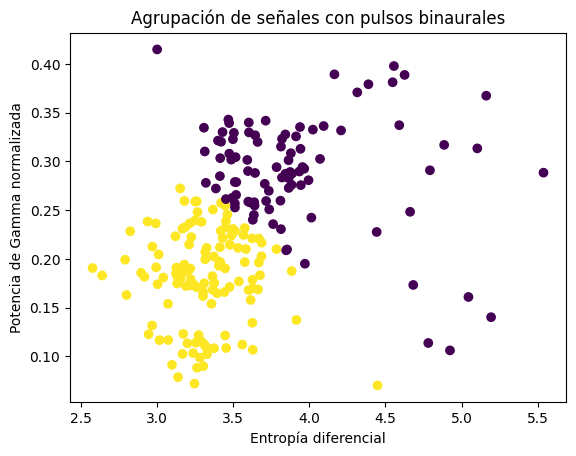

In [ ]:
epochs_trained_1['k_means2'] = kmeans.labels_
display(epochs_trained_1)
plt.scatter(x=epochs_trained_1['DE'],y=epochs_trained_1['Power Gamma Normalized'],c=epochs_trained_1['k_means2'])
plt.xlabel('Entropía diferencial')
plt.ylabel('Potencia de Gamma normalizada')
plt.title('Agrupación de señales con pulsos binaurales')
plt.savefig('kmeans_ea_con_pulsos.eps',format='eps')
plt.show()